# Gaussian Process Regression with Networks

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
import scipy.optimize as so
import matplotlib.patches as mpatches
import networkx as nx
import pandas as pd
import random

In [2]:
def net_logPosterior(theta,*args):
    Graph,distancematrix, data,t = args
    #k = kernel(data,data,theta,wantderiv=False)
    k = net_kernel(Graph,distancematrix, data,data,theta,wantderiv=False)
    L = np.linalg.cholesky(k)
    beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,t))
    logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - np.shape(data)[0] /2. * np.log(2*np.pi)
    return -logp

def net_gradLogPosterior(theta,*args):
    #print(args)
    Graph,distancematrix, data,t = args
    theta = np.squeeze(theta)
    d = len(theta)
    #K = kernel(data,data,theta,wantderiv=True)
    K = net_kernel(Graph,distancematrix, data, data, theta, wantderiv=True)

    L = np.linalg.cholesky(np.squeeze(K[:,:,0]))
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(data)[0])))
    dlogpdtheta = np.zeros(d)
    for d in range(1,len(theta)+1):
        dlogpdtheta[d-1] = 0.5*np.dot(t.transpose(), np.dot(invk, np.dot(np.squeeze(K[:,:,d]), np.dot(invk,t)))) - 0.5*np.trace(np.dot(invk,np.squeeze(K[:,:,d])))

    return -dlogpdtheta

def shortest_path_graph_distances(Graph):
    #shortest_paths_lengths = dict(nx.all_pairs_shortest_path_length(G))
    shortest_paths_lengths = dict(nx.all_pairs_shortest_path_length(Graph))
    dist = pd.DataFrame(shortest_paths_lengths).sort_index(axis=1)
    return dist

def squared_exponential(dist, params):
    return params[0]*np.exp(-.5 * (1/params[1]) * dist)

def net_kernel(Graph,graph_distance_matrix, nodes_a,nodes_b,theta,measnoise=1., wantderiv=True, print_theta=False):
    # Uses exp(theta) to ensure positive hyperparams
    theta = np.squeeze(theta)
    theta = np.exp(theta)
    #graph_distance_matrix = shortest_path_graph_distances(Graph)
    nodelist = list(Graph.nodes)
    nodeset = set(nodes_a).union(set(nodes_b))
    nodes_to_drop = [x for x in nodelist if x not in nodeset]
    cols_to_drop = set(nodes_to_drop).union(set(nodes_b) - set(nodes_a))
    rows_to_drop = set(nodes_to_drop).union(set(nodes_a) - set(nodes_b))
    p = graph_distance_matrix.drop(cols_to_drop).drop(rows_to_drop, 1)
    distances = p.values
    
    d1 = len(nodes_a)
    d2 = len(nodes_b)
  
    k = theta[0] * np.exp(-0.5*distances)
    
    if wantderiv:
        K = np.zeros((d1,d2,len(theta)+1))
        # K[:,:,0] is the original covariance matrix
        K[:,:,0] = k + measnoise*theta[2]*np.eye(d1,d2)
        K[:,:,1] = k
        K[:,:,2] = -0.5*k*distances
        K[:,:,3] = theta[2]*np.eye(d1,d2)
        return K
    else:
        return k + measnoise*theta[2]*np.eye(d1,d2)
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [3]:
lattice_m = 15
lattice_n = 15
N = 100     # numero punti training
n = 90    # numero punti test
deg = 4 #connectivity degree
#%%
#G = nx.random_regular_graph(deg, N+n + 10)
G = nx.generators.lattice.grid_graph(dim = [lattice_m,lattice_n],periodic= False)
G = nx.relabel_nodes(G, dict(zip(G,range(len(G.nodes)))))

In [4]:
random.seed(0)

#training_nodes = list(G.nodes)[0:N]
training_nodes = random.sample(list(G.nodes), N)
training_nodes.sort()

#test_nodes = list(G.nodes)[N:N+n]
test_nodes = random.sample((set(G.nodes) - set(training_nodes)), n)
test_nodes.sort()

othernodes = set(G.nodes) - set(training_nodes) - set(test_nodes)
othernodes = list(othernodes)
othernodes.sort()

In [5]:
dist = shortest_path_graph_distances(G)

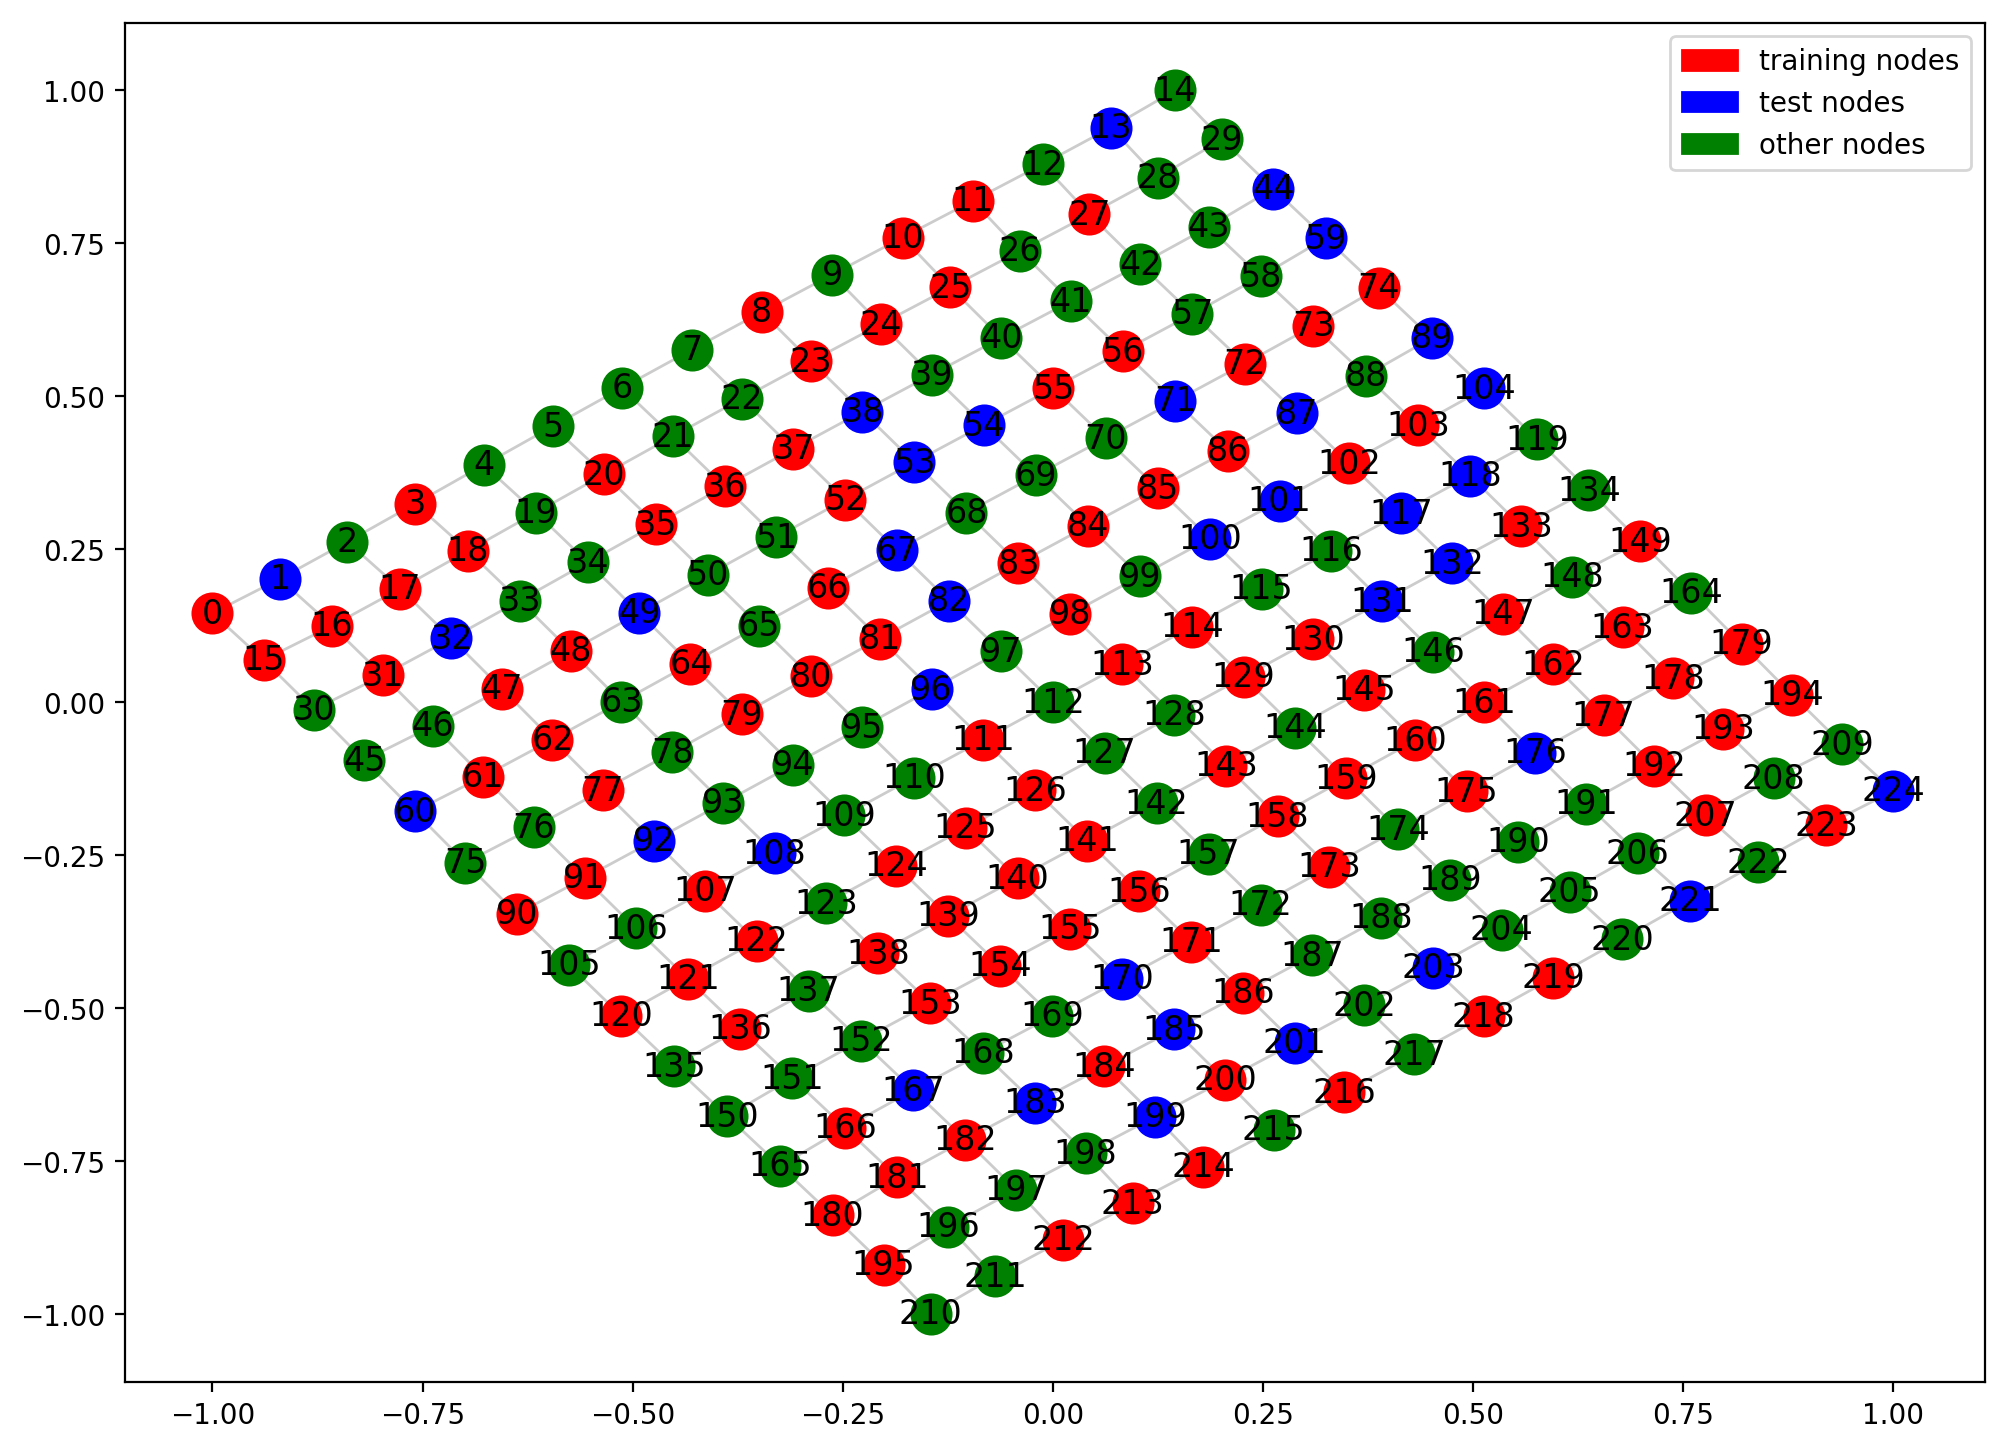

In [6]:
pl.figure(dpi = 200, figsize=[12,9])
#node positions
pos = nx.kamada_kawai_layout(G)
#draw nodes
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=200, nodelist=training_nodes, node_color="r")
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=200, nodelist=test_nodes, node_color="g")
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=200, nodelist=othernodes, node_color="b")
#draw edges
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
#legend
labels = nx.draw_networkx_labels(G, pos=pos, font_color='k')
red_patch = mpatches.Patch(color='red', label='training nodes')
blue_patch = mpatches.Patch(color='blue', label='test nodes')
green_patch = mpatches.Patch(color='green', label='other nodes')
pl.legend(handles=[red_patch, blue_patch, green_patch])

In [7]:
#uso come funzione di prova la distanza dal nodo 0
pivot_distance = pd.Series(dict(nx.single_source_shortest_path_length(G,0))).sort_index()
t = pivot_distance[training_nodes]

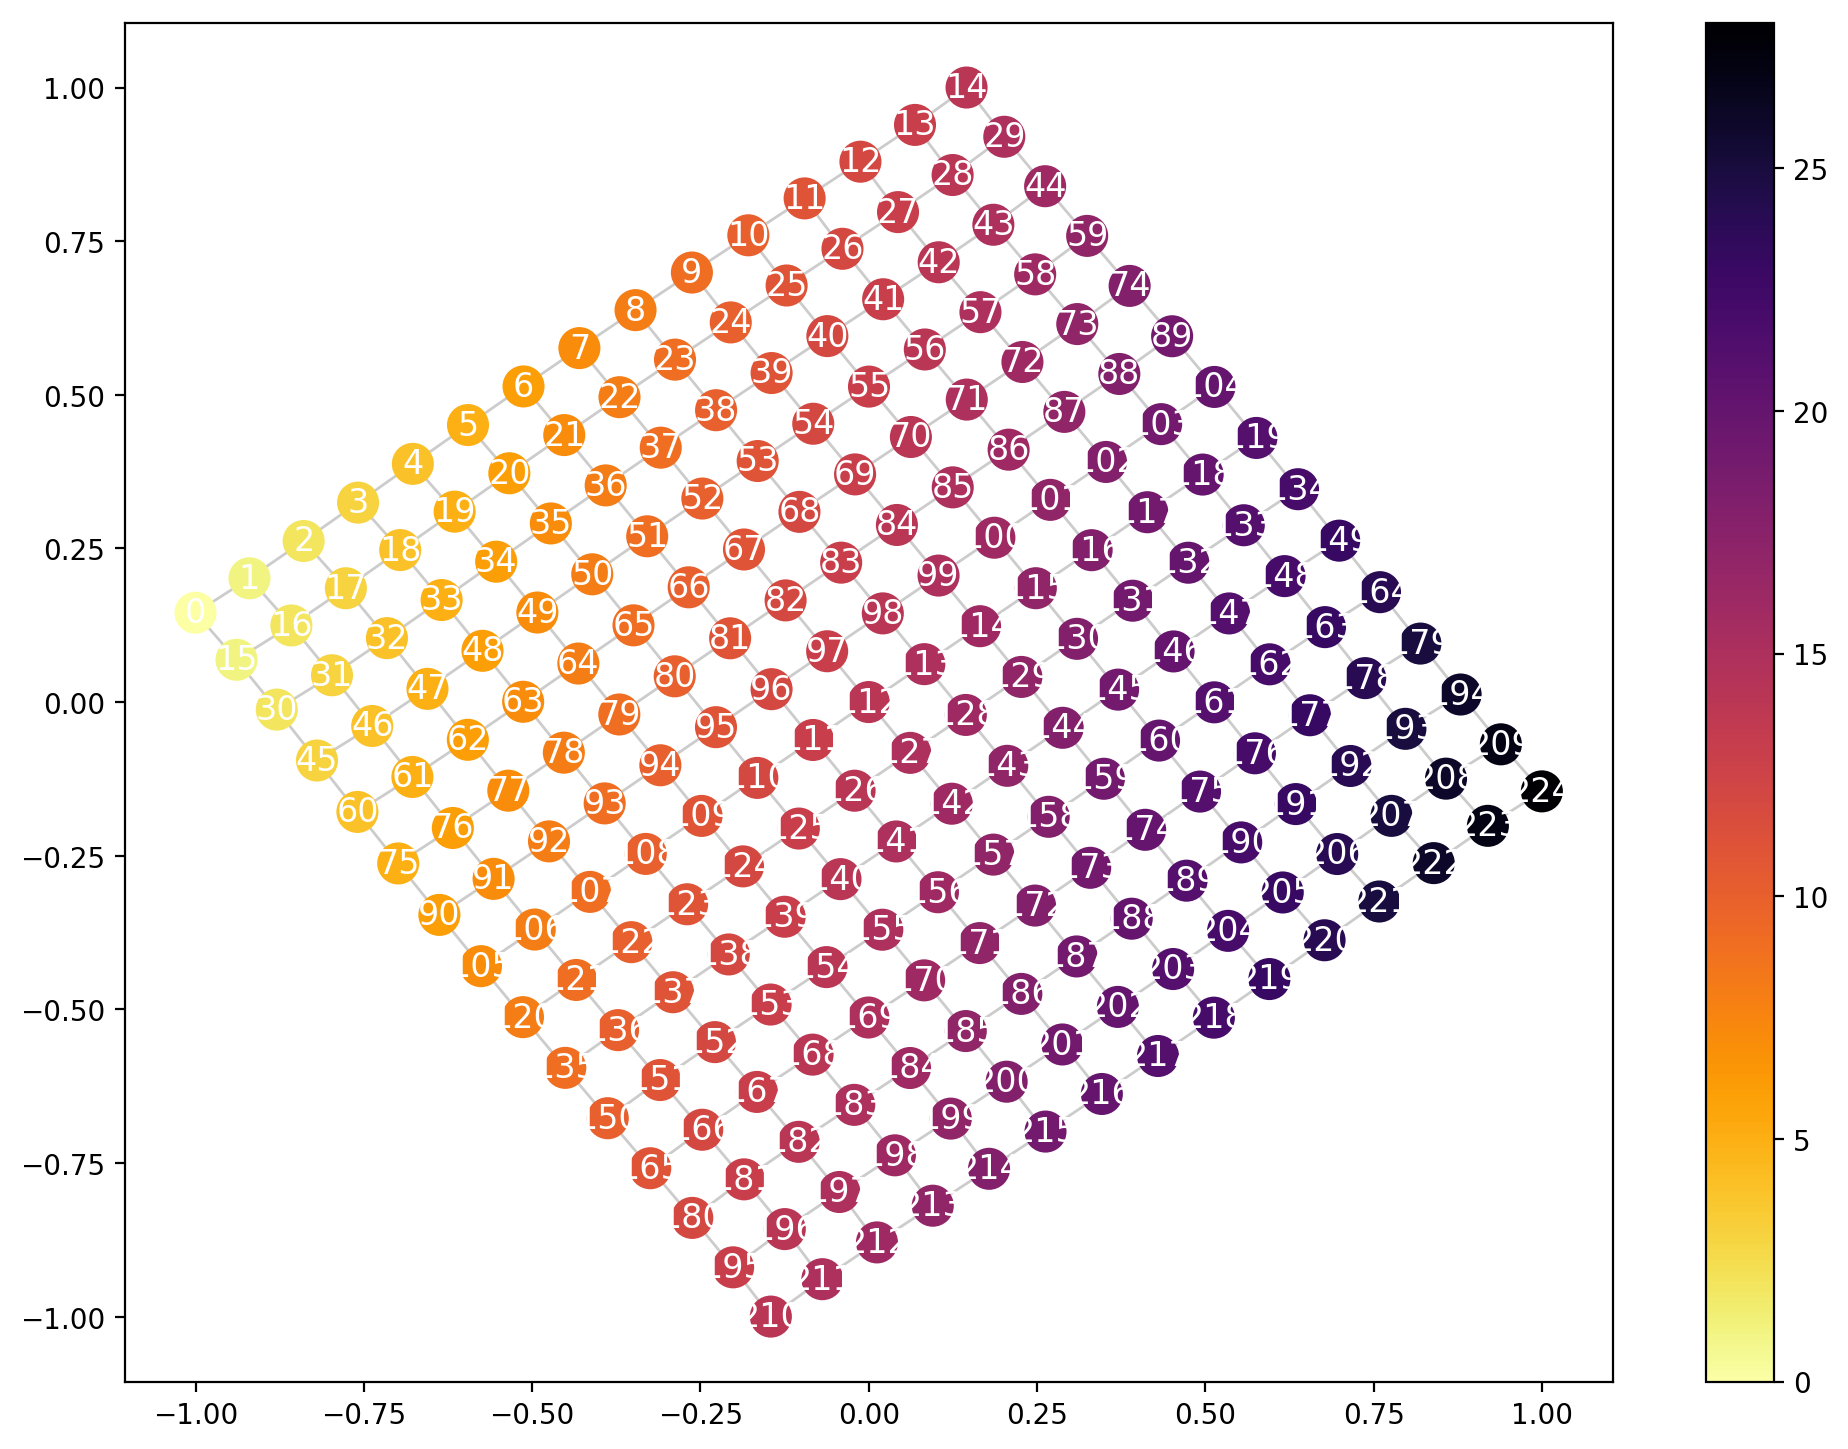

In [8]:
pl.figure(dpi = 200, figsize=[12,9])
vmin = pivot_distance.min()
vmax = pivot_distance.max() 
cmap = pl.cm.inferno_r

sm = pl.cm.ScalarMappable(cmap=cmap, norm=pl.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = pl.colorbar(sm)

nx.draw_networkx_nodes(G,pos, node_color=pivot_distance,with_labels=True, node_size=200, cmap=pl.cm.inferno_r)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
labels = nx.draw_networkx_labels(G, pos=pos, font_color='w')

In [9]:
lengthscale = 1
constantscale = 1
noise_scale = 1
theta = np.array([constantscale, lengthscale, noise_scale])

theta = so.fmin_cg(net_logPosterior, theta, fprime=net_gradLogPosterior, args=(G,dist,training_nodes,t), gtol=1e-5,maxiter=200,disp=1)
if theta.shape == (1,3):
    print("l'ottimizzatore fa i capricci, cambio dimensioni")
    theta = theta[0]

         Current function value: 315.152816
         Iterations: 1
         Function evaluations: 61
         Gradient evaluations: 50


In [10]:
k = net_kernel(G, dist, training_nodes, training_nodes, theta, wantderiv=False)
assert (is_pos_def(k)), "Autocorrelation Matrix has to be positive-definite, try using a different nework shape, distance metric or kernel"
kstar = net_kernel(G, dist, test_nodes, training_nodes, theta, wantderiv=False, measnoise=False)
kstarstar = net_kernel(G, dist, test_nodes, test_nodes,theta, wantderiv=False)
kstarstar_diag = np.diag(kstarstar)
#%%
L = np.linalg.cholesky(k)
invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(len(training_nodes))))

mean = np.squeeze(np.dot(kstar,np.dot(invk,t)))
var = kstarstar_diag - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
var = np.squeeze(np.reshape(var,(n,1)))
s = np.sqrt(var)

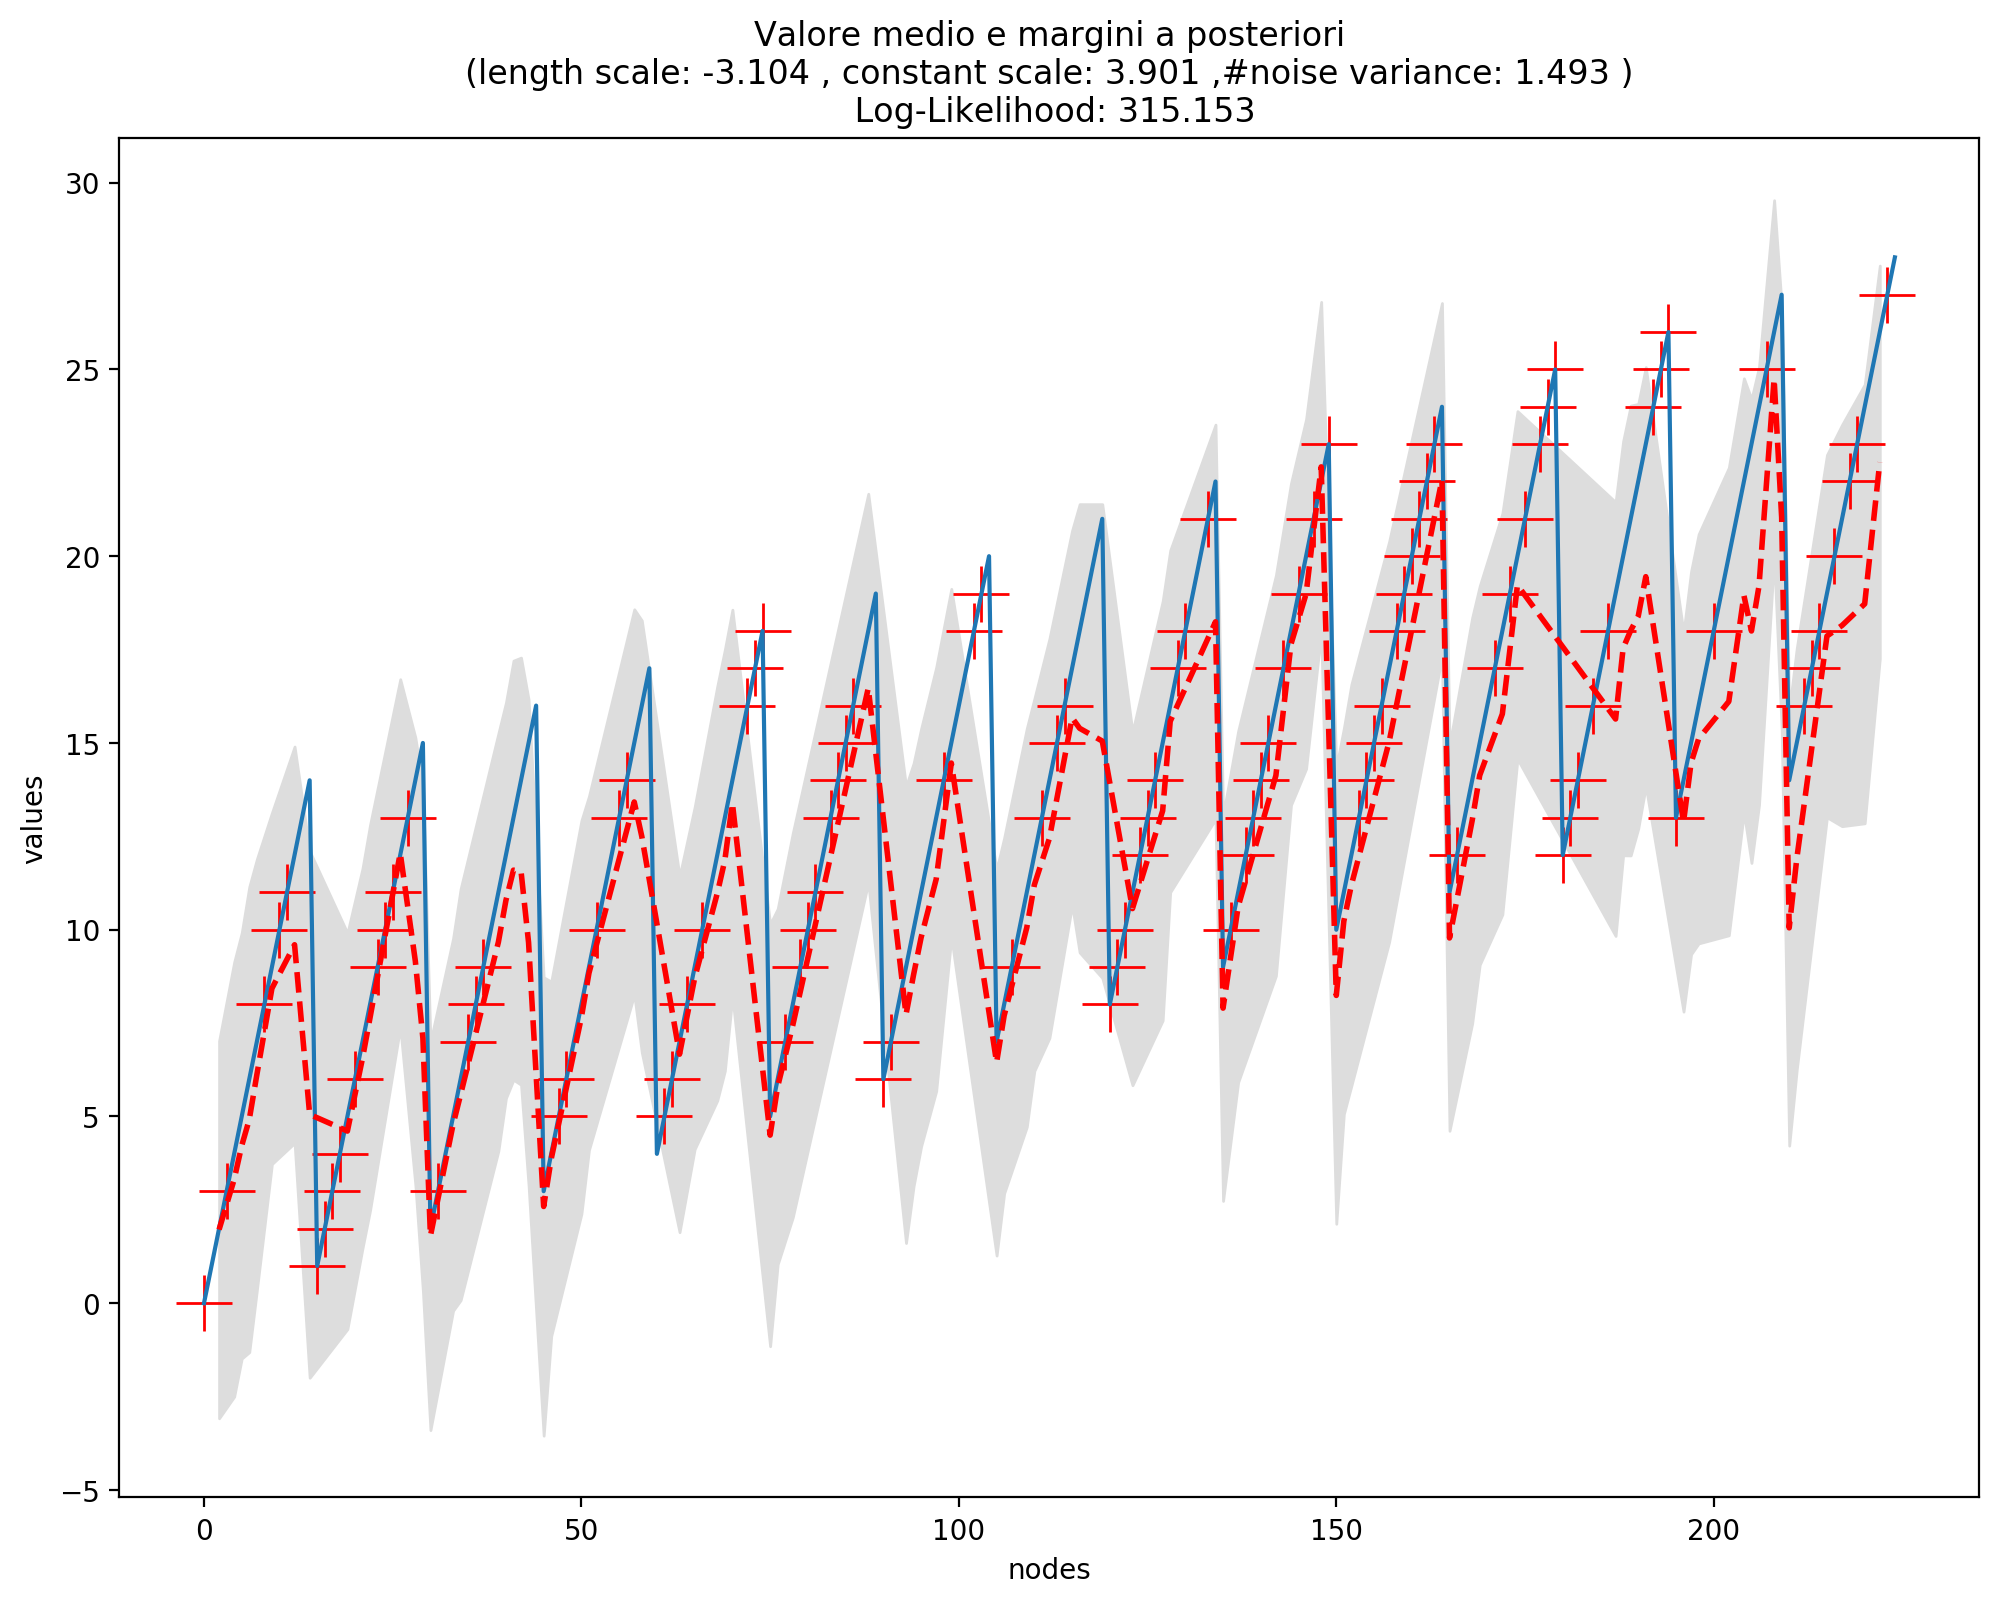

In [11]:
pl.figure(dpi = 200, figsize=[12,9])
pl.clf()
pl.plot(training_nodes, pivot_distance[training_nodes], 'r+', ms=20)
pl.plot(pivot_distance)
pl.gca().fill_between(test_nodes, mean-s, mean+s, color="#dddddd")
pl.plot(test_nodes, mean, 'r--', lw=2)
pl.title('Valore medio e margini di confidenza')
loglikelihood = net_logPosterior(theta,G,dist,training_nodes,t)
pl.title('Valore medio e margini a posteriori\n(length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (theta[1], theta[0], theta[2], loglikelihood))
pl.xlabel('nodes')
pl.ylabel('values')
pl.savefig('predict.png', bbox_inches='tight')

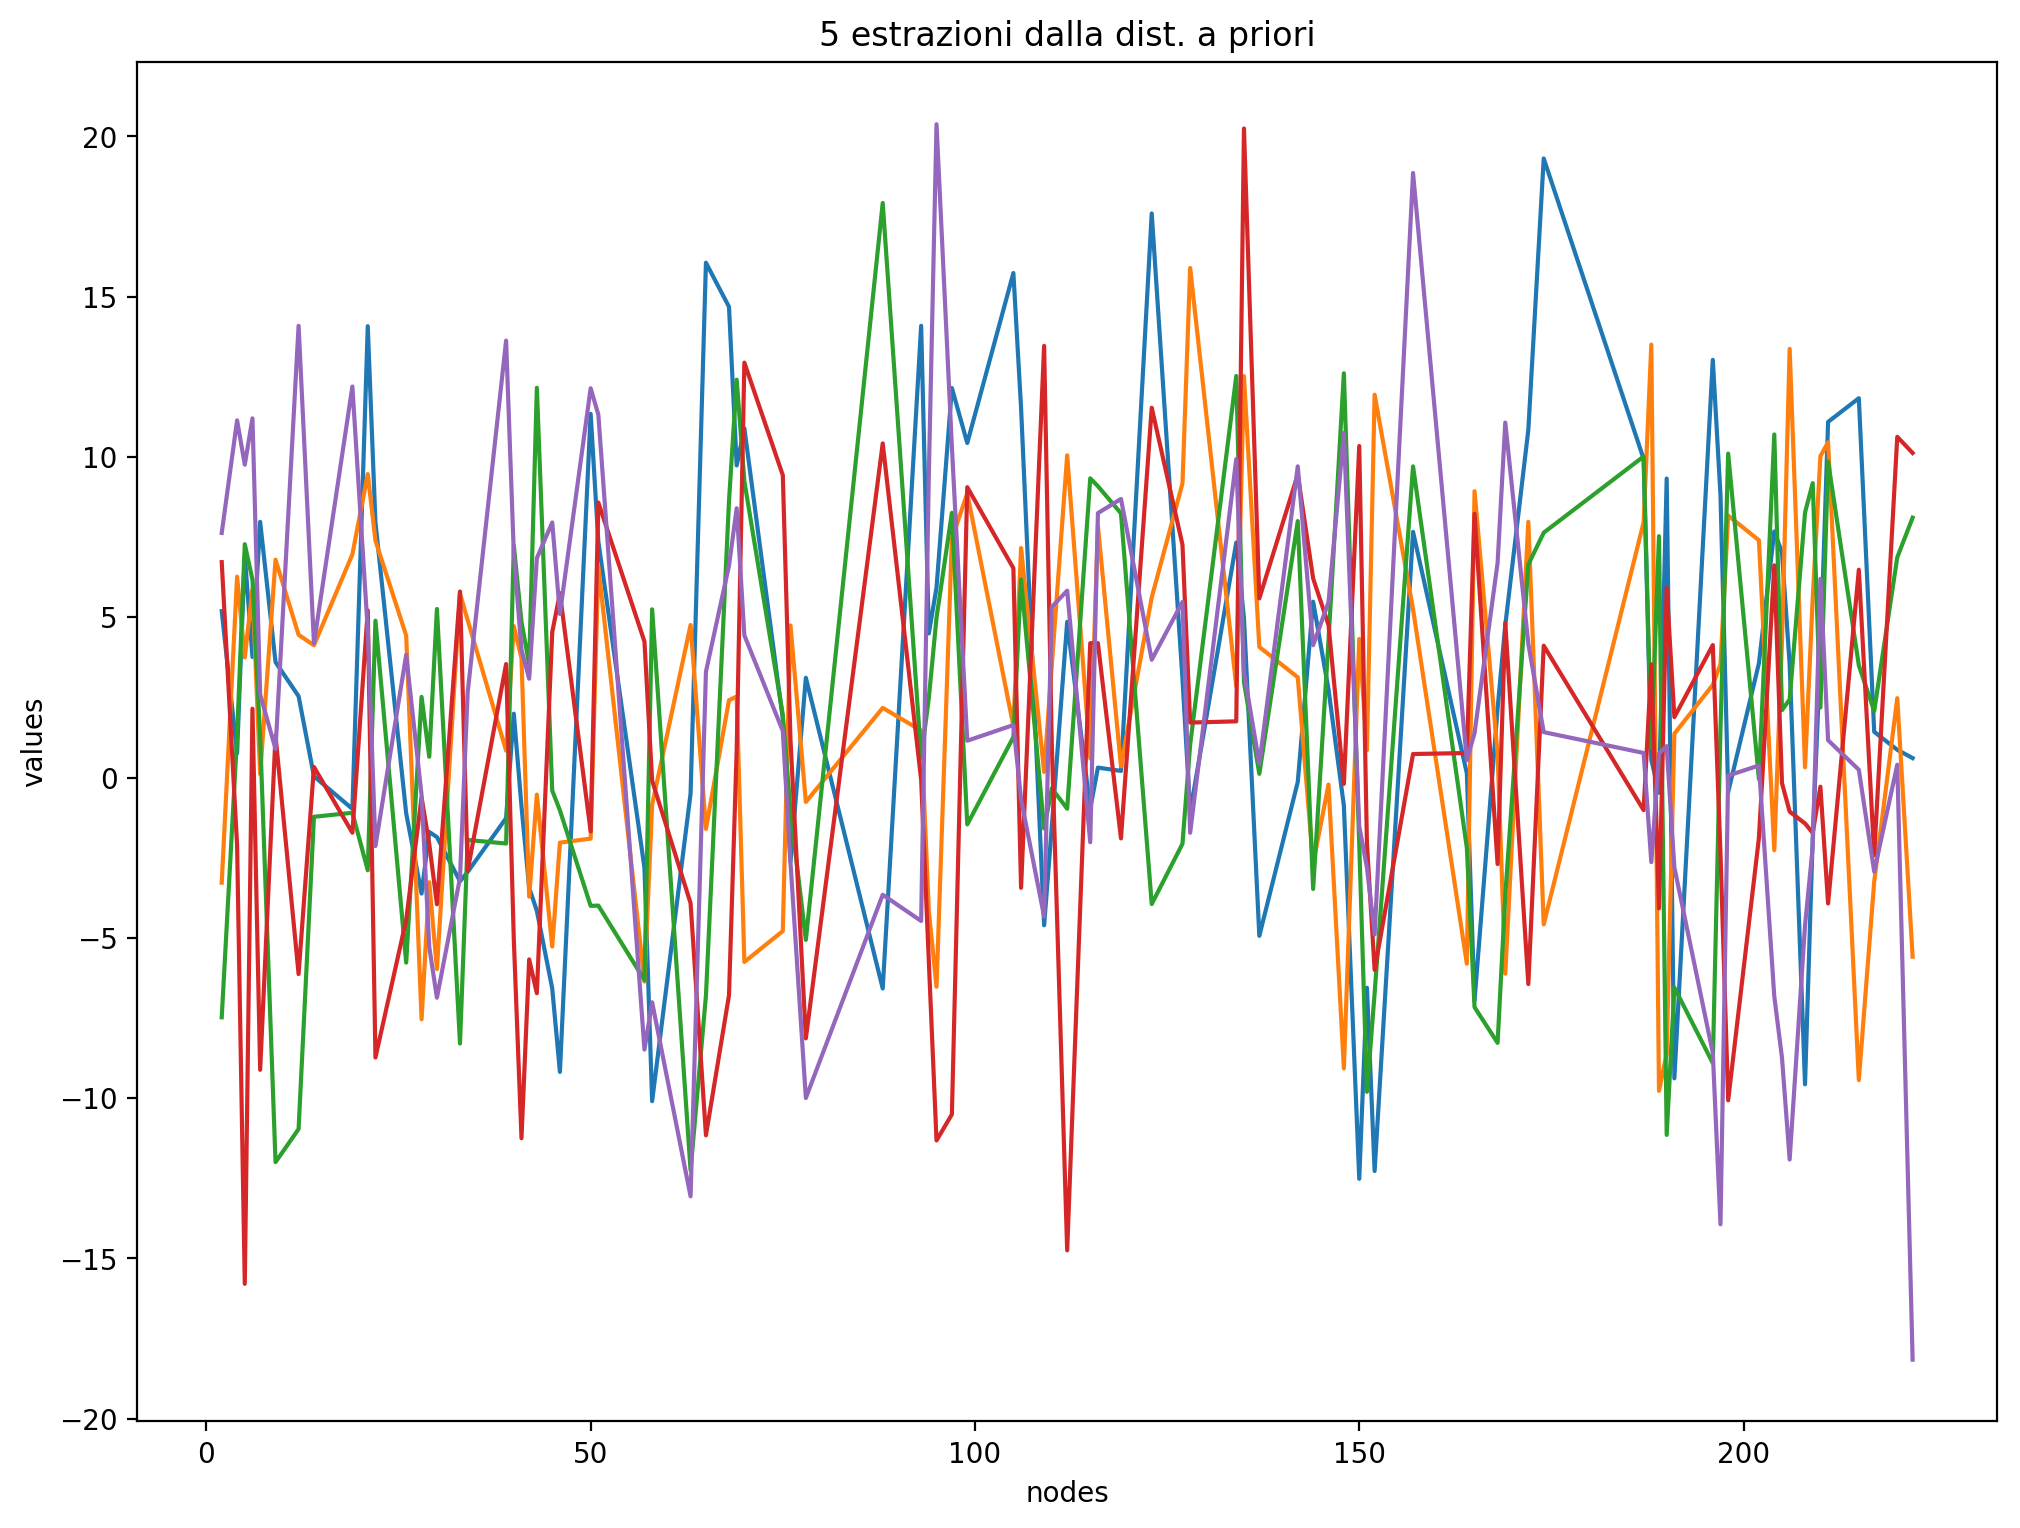

In [12]:
L2 = np.linalg.cholesky(kstarstar + 1e-6*np.eye(n))
#f_prior = mu L*N(0,1)
f_prior = np.dot(L2, np.random.normal(size=(n,5)))
pl.figure(dpi = 200, figsize=[12,9])
pl.clf()
pl.plot(test_nodes, f_prior)
pl.title('5 estrazioni dalla dist. a priori')
pl.xlabel('nodes')
pl.ylabel('values')
#pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

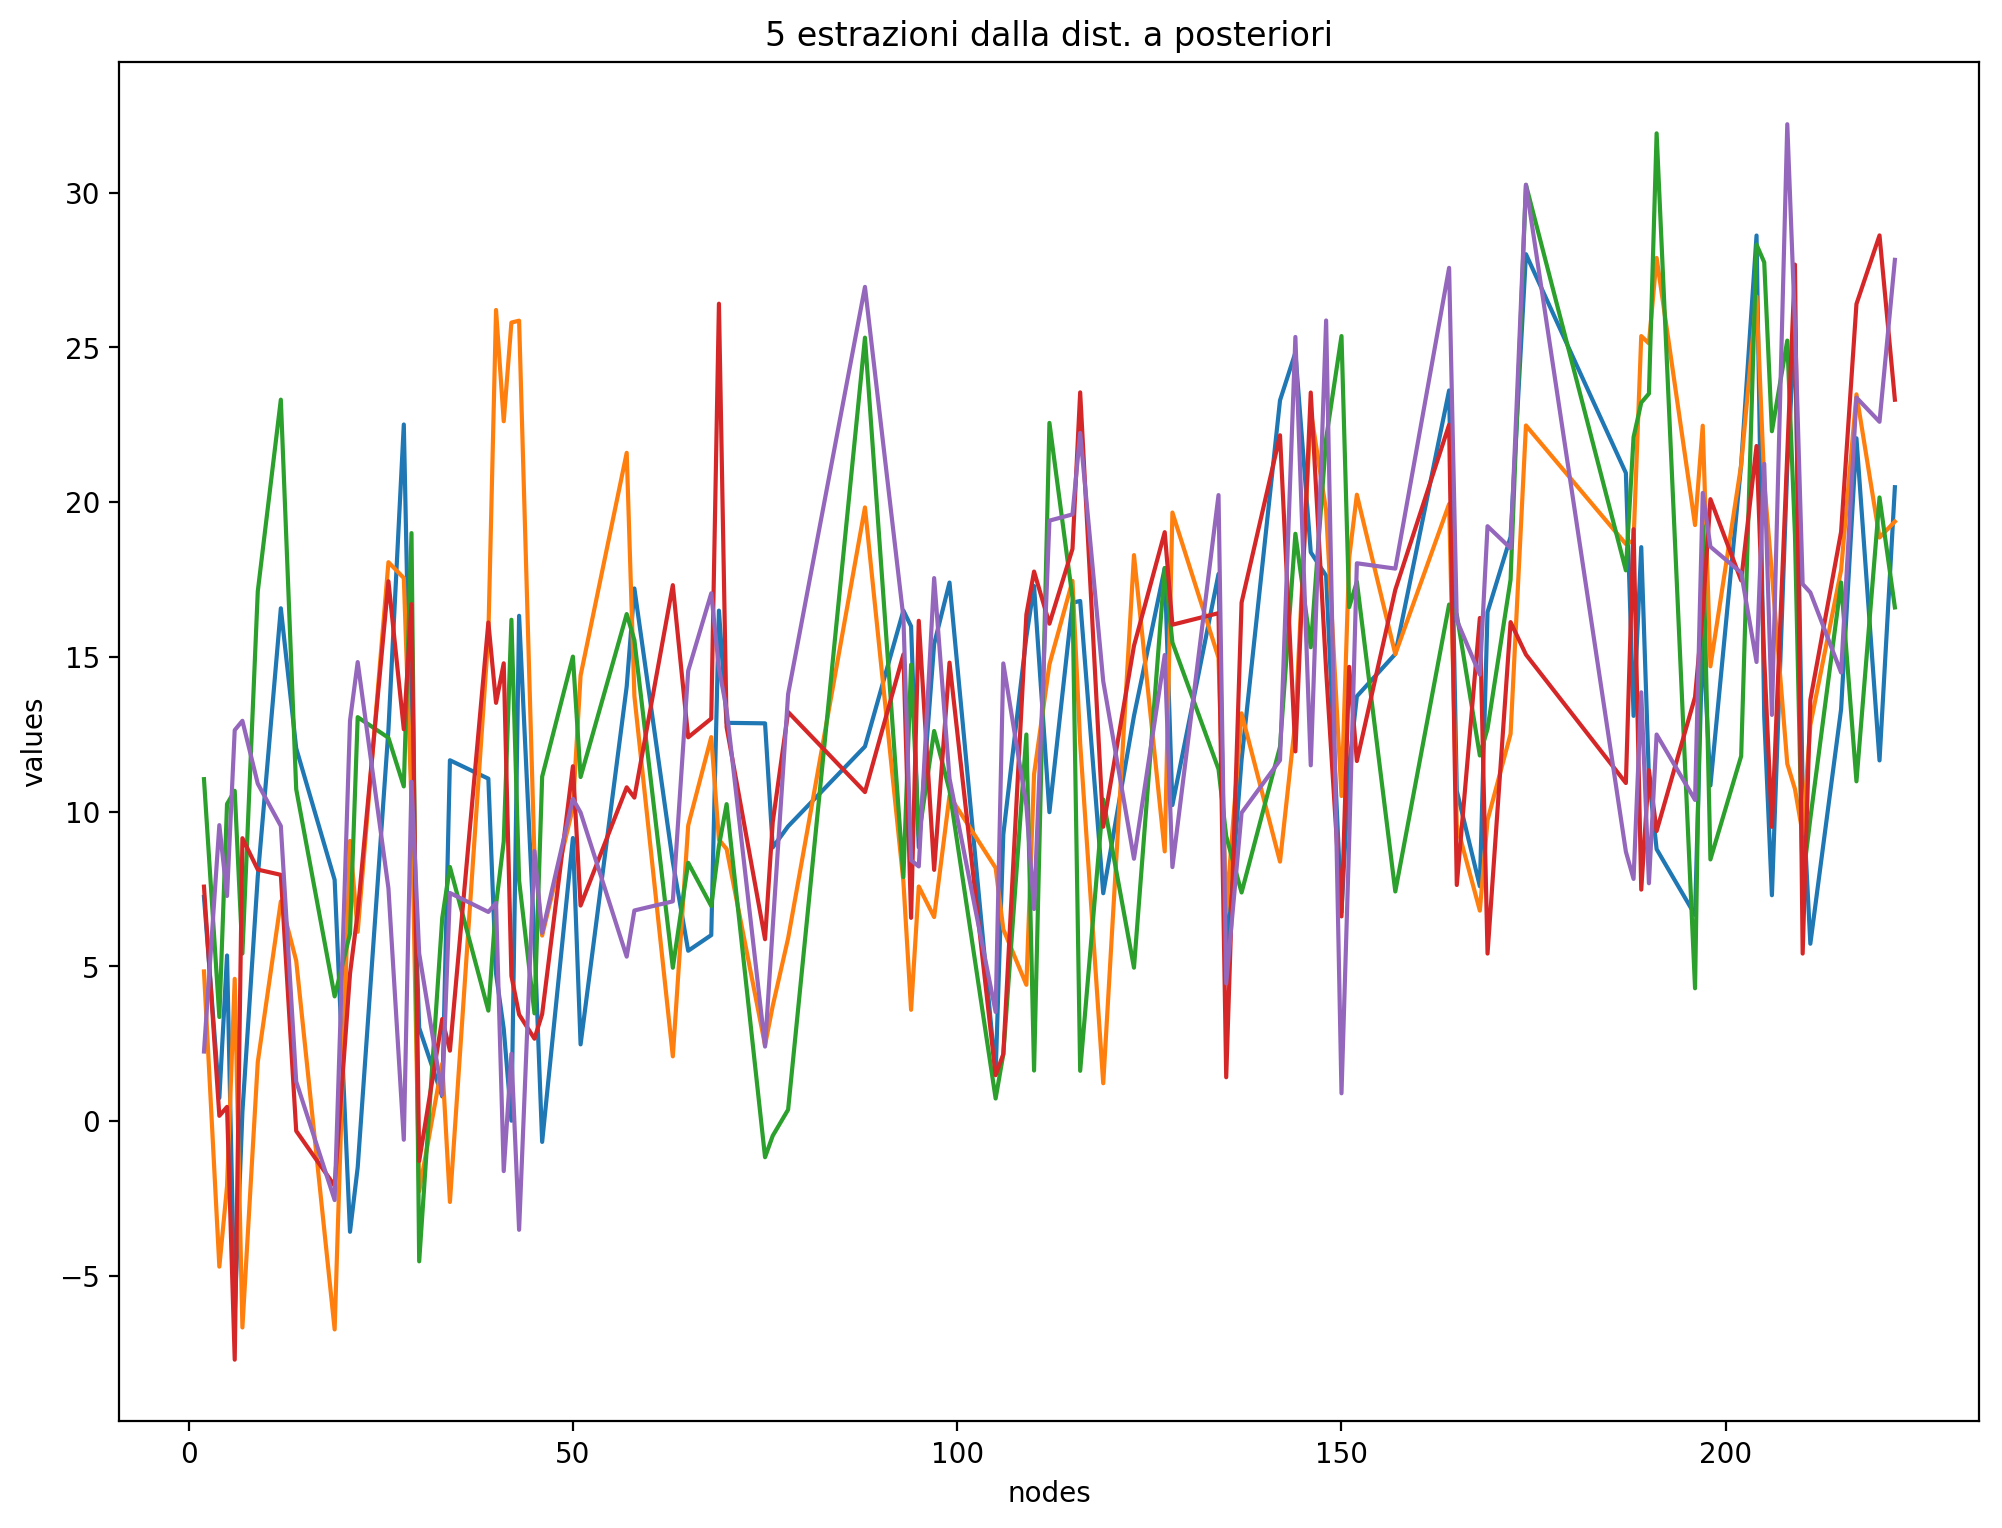

In [13]:
Lk = np.linalg.solve(L, kstar.T)
L2 = np.linalg.cholesky(kstarstar+ 1e-6*np.eye(n) - np.dot(Lk.T, Lk))

#f_post = mu + L*N(0,1)
f_post = mean.reshape(-1,1) + np.dot(L2, np.random.normal(size=(n,5)))
pl.figure(dpi = 200, figsize=[12,9])
pl.clf()
pl.plot(test_nodes, f_post)
pl.title('5 estrazioni dalla dist. a posteriori')
pl.xlabel('nodes')
pl.ylabel('values')
#pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

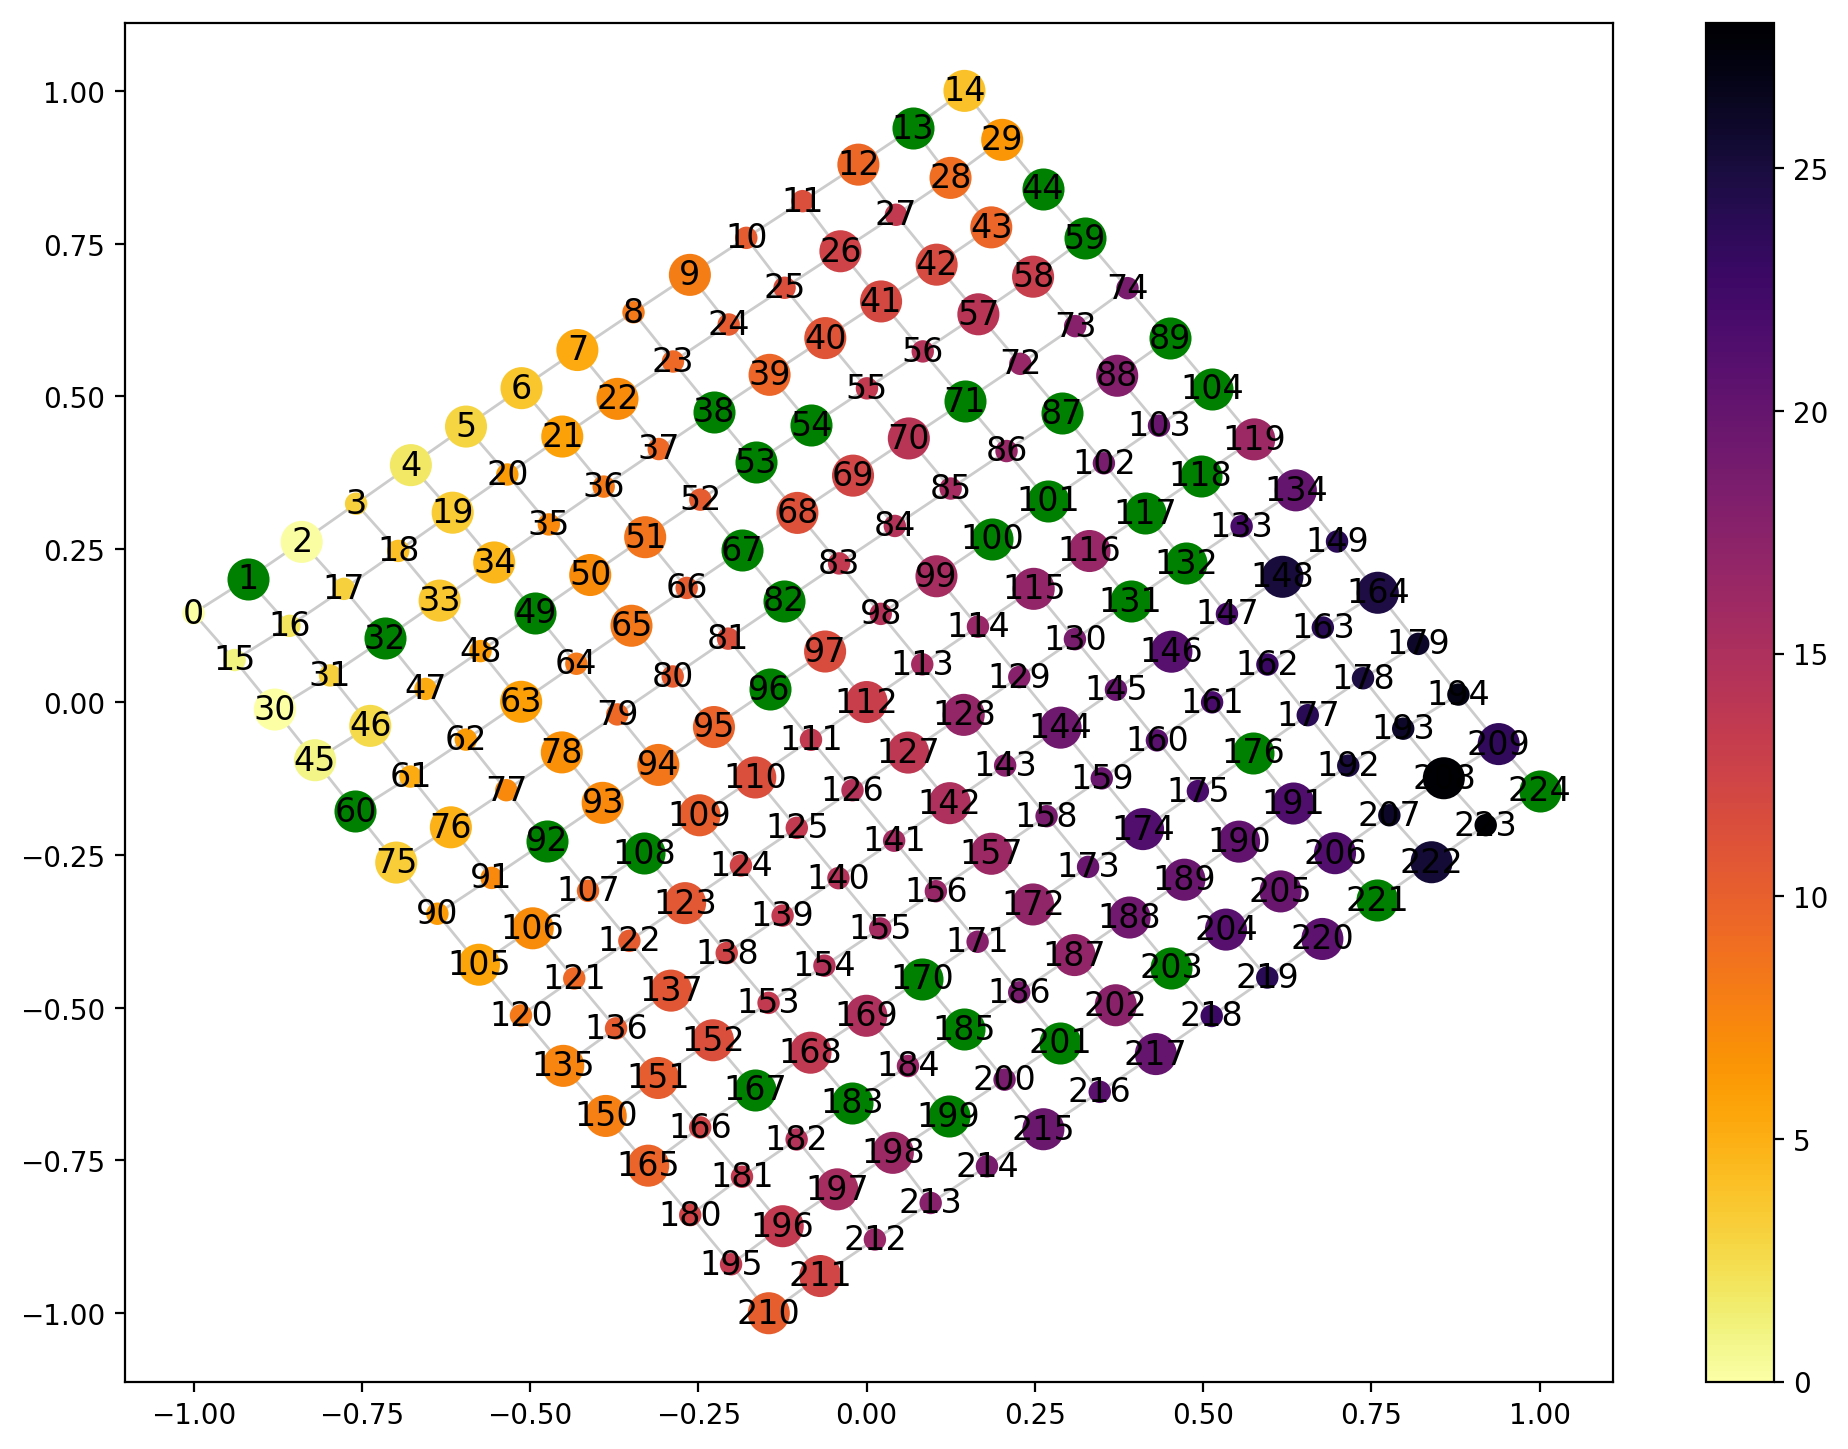

In [14]:
pl.figure(dpi = 200, figsize=[12,9])

training_nodes_colors  = [pivot_distance[node] for node in training_nodes]

nx.draw_networkx_nodes(G,pos,nodelist=training_nodes, node_color=pivot_distance[(training_nodes)],with_labels=True, node_size=50, cmap=cmap)
nx.draw_networkx_nodes(G,pos,nodelist=othernodes, node_color="g", with_labels=True, node_size=200, cmap=cmap)
nx.draw_networkx_nodes(G,pos,nodelist=test_nodes, node_color=mean, with_labels=True, node_size=200, cmap=cmap)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
cbar = pl.colorbar(sm)
labels = nx.draw_networkx_labels(G, pos=pos, font_color='k')